# Сервис кикшеринга

### Импорты

In [436]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import datetime as dt

### Функции

In [437]:
def pass_value_barh(df, df_tittle):
    try:
        (
            (df.isna().mean() * 100)
            .to_frame()
            .rename(columns={0: "space"})
            .query("space > 0")
            .sort_values(by="space", ascending=True)
            .plot(kind="barh", figsize=(10, 5), rot=0, legend=False, fontsize=12)
            .set_title(
                f'Доля пропусков в столбцах датафрейма "{df_tittle}" (%)' + "\n",
                fontsize=16,
                color="SteelBlue",
            )
        )
    except:
        print("Пропусков нет")


def streets_format(tdf, column):
    tdf[column] = tdf[column].str.lower()
    tdf[column] = tdf[column].replace(regex=r"ул\.?\s?", value="")
    return tdf


def rayons_format(tdf, column):
    tdf[column] = tdf[column].str.lower()
    tdf[column] = tdf[column].replace(regex=r"\s", value="-")
    return tdf


def cat_graph(df, cat_feat, tittle):
    params = {
        "axes.labelsize": 12,
        "figure.titlesize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
    plt.rcParams.update(params)

    colors = sns.color_palette("pastel")[0:10]

    cols = 2
    num_features = len(cat_feat)
    rows = int(np.ceil(num_features / cols)) if num_features > 0 else 1

    fig, axs = plt.subplots(rows, cols, figsize=(10, 5 * rows))

    axs_flat = axs.flatten()

    for count, col in enumerate(cat_feat):
        if count >= len(axs_flat):
            break

        ax = axs_flat[count]

        df1 = pd.DataFrame(df.groupby([col])[col].count())
        ax.pie(
            x=df1[col],
            colors=colors,
            labels=df1.index,
            autopct="%1.1f%%",
            textprops={"fontsize": 10},
        )
        ax.title.set_text(str(col))

    for k in range(num_features, len(axs_flat)):
        fig.delaxes(axs_flat[k])

    plt.suptitle(f"Круговые диаграммы категориальных признаков {tittle}", y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


def plot_hist(data, col_column, tittle):
    rows = len(col_column)

    if rows == 0:
        print("Список количественных признаков пуст.")
        return

    f, ax = plt.subplots(rows, 2, figsize=(14, 8 * rows))
    f.tight_layout()
    f.set_figheight(5 * rows)
    f.set_figwidth(14)
    plt.rcParams.update({"font.size": 18})

    ax_flat = ax.flatten()

    for i, col in enumerate(col_column):

        ax_hist = ax_flat[i * 2]
        ax_box = ax_flat[i * 2 + 1]

        sns.histplot(data[col], kde=True, bins=15, ax=ax_hist)
        sns.boxplot(x=data[col], ax=ax_box)

        ax_hist.set_xlabel(col)
        ax_box.set_xlabel(col)
        ax_hist.set_ylabel("Количество")

    plt.suptitle(
        f"Гистограмма и ящик с усами для количественных данных {tittle}",
        fontsize=22,
        y=1.01,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


def integer_data(df):
    numeric_cols = df.select_dtypes(include=[int, float]).columns
    return numeric_cols


def categorial_data(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    return categorical_cols


def ejection(x):
    x[(x > 1000000) | (x < 10)] = None
    return x

### Загрузка датасетов

In [438]:
df_rides = pd.read_csv("datasets/rides.csv", sep=",", encoding="utf-8")
df_weather = pd.read_csv(
    "datasets/weather.csv", sep=",", encoding="utf-8", skiprows=[1]
)  # т.к. 1 строка содержит только единицы измерения и портит дальнейший анализ
df_rides.columns = df_rides.columns.str.lower().str.replace(" ", "_")
df_weather.columns = df_weather.columns.str.lower().str.replace(" ", "_")

### Первичный просмотр датасетов

#### Датасет поездок

In [439]:
df_rides.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515.0,0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520.0,0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0


Как мы видим, есть опечатки, связанные с регистром

In [440]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102255 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              102255 non-null  int64  
 1   start_date      102255 non-null  object 
 2   end_date        102255 non-null  object 
 3   start_location  102255 non-null  object 
 4   start_district  102255 non-null  object 
 5   end_location    102255 non-null  object 
 6   end_district    102255 non-null  object 
 7   distance        101022 non-null  float64
 8   promo           102255 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 7.0+ MB


In [441]:
df_rides["promo"].unique()

array([0, 1])

столбцы ***_date нужно перевести в тип datetime

т.к. промо столбец принимает только 0 и 1 переведём его в bool

In [442]:
df_rides.shape

(102255, 9)

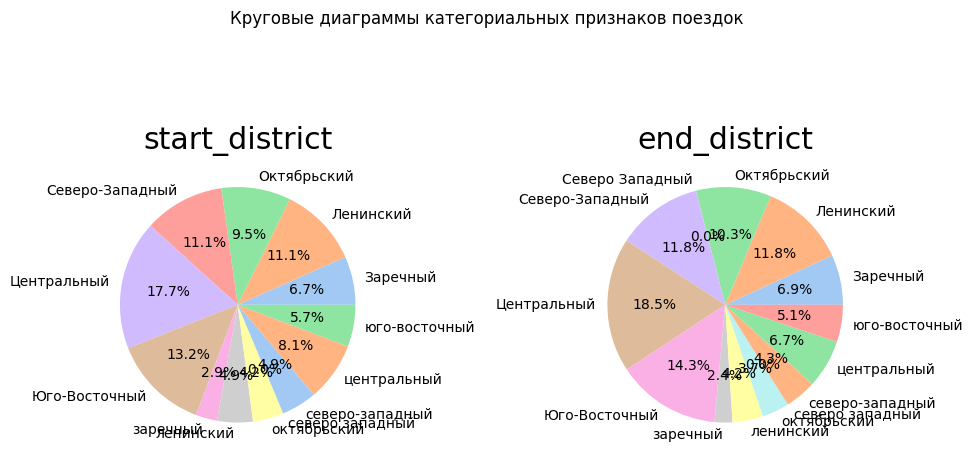

In [443]:
cat_graph(df_rides, ["start_district", "end_district"], "поездок")

Также есть опечатки в виде отсутствия "-", а также регистр.

In [444]:
df_rides["start_location"].unique()[:30]

array(['Шевченко', 'Чехова', 'Буденного', 'Труда', 'Первомайская',
       'Лесная', 'Пролетарская', 'Комарова', 'Западная', 'Свободы',
       'Коммунальная', 'Зеленая', 'Шоссейная', 'Центральная', 'буденного',
       'новая', 'Энтузиастов', 'ул.подгорная', 'Восточная', 'Лермонтова',
       'Школьная', 'Пушкина', 'подгорная', 'рябиновая', 'Солнечная',
       'Мичурина', 'ул труда', 'Партизанская', 'Вокзальная',
       'Комсомольская'], dtype=object)

In [445]:
df_rides["end_location"].unique()[:30]

array(['Майская', 'Спортивная', 'Суворова', 'Рабочая', 'Юбилейная',
       'Западная', 'Свободы', 'ул. западная', 'Озерная', 'ул. чкалова',
       'Строителей', 'ул. спортивная', 'Красная', 'Ул. Крупской',
       'ул.почтовая', 'гоголя', 'Сиреневая', 'ул.южная', 'Шоссейная',
       'Трудовая', 'Дружбы', 'Почтовая', 'Южная', 'космонавтов',
       'шевченко', 'ул. набережная', 'вишневая', 'Совхозная',
       'ул сосновая', 'ул. вишневая'], dtype=object)

видим опечатки связанные с присутствием/отсуствием ул. 
так что уберём ул и точки из всех улиц

#### Датасет погоды

In [446]:
df_weather.head(5)

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,2023-04-01T00:00:00,8.740245,0.1,48.60,21.638964,90.0,0.0
1,2023-04-01T01:00:00,9.040245,0.2,55.44,22.493519,74.0,0.0
2,2023-04-01T02:00:00,8.880245,0.3,55.80,22.264770,72.0,0.0
3,2023-04-01T03:00:00,8.690246,0.3,55.44,21.945240,77.0,0.0
4,2023-04-01T04:00:00,8.630245,0.3,48.96,22.424270,78.0,0.0


In [447]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             3672 non-null   object 
 1   temperature          3617 non-null   float64
 2   precipitation_total  3642 non-null   float64
 3   wind_gust            3672 non-null   float64
 4   wind_speed           3656 non-null   float64
 5   cloud_cover_total    3652 non-null   float64
 6   sunshine_duration    3660 non-null   float64
dtypes: float64(6), object(1)
memory usage: 200.9+ KB


Размер датасета, а значит и количество измерений

In [448]:
df_weather.shape

(3672, 7)

найдём количество дней измерений

In [449]:
df_weather.shape[0] / 24

153.0

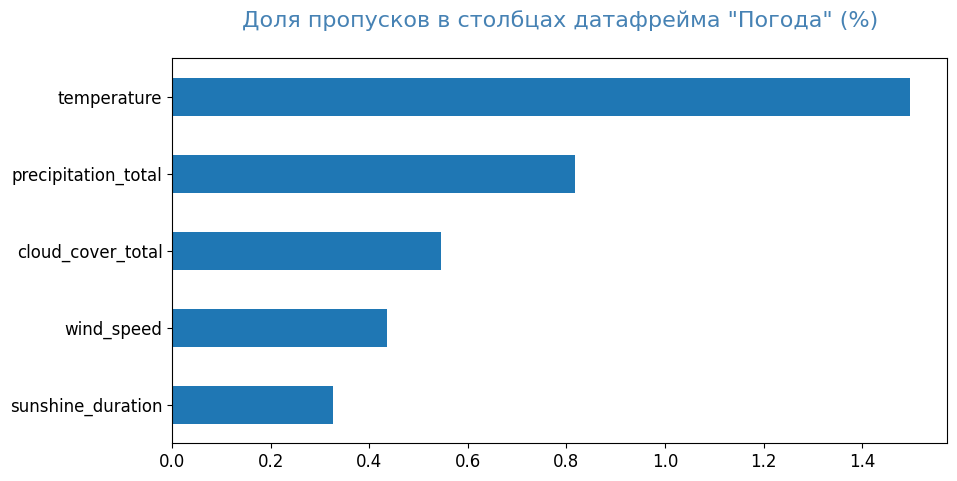

In [450]:
pass_value_barh(df_weather, "Погода")

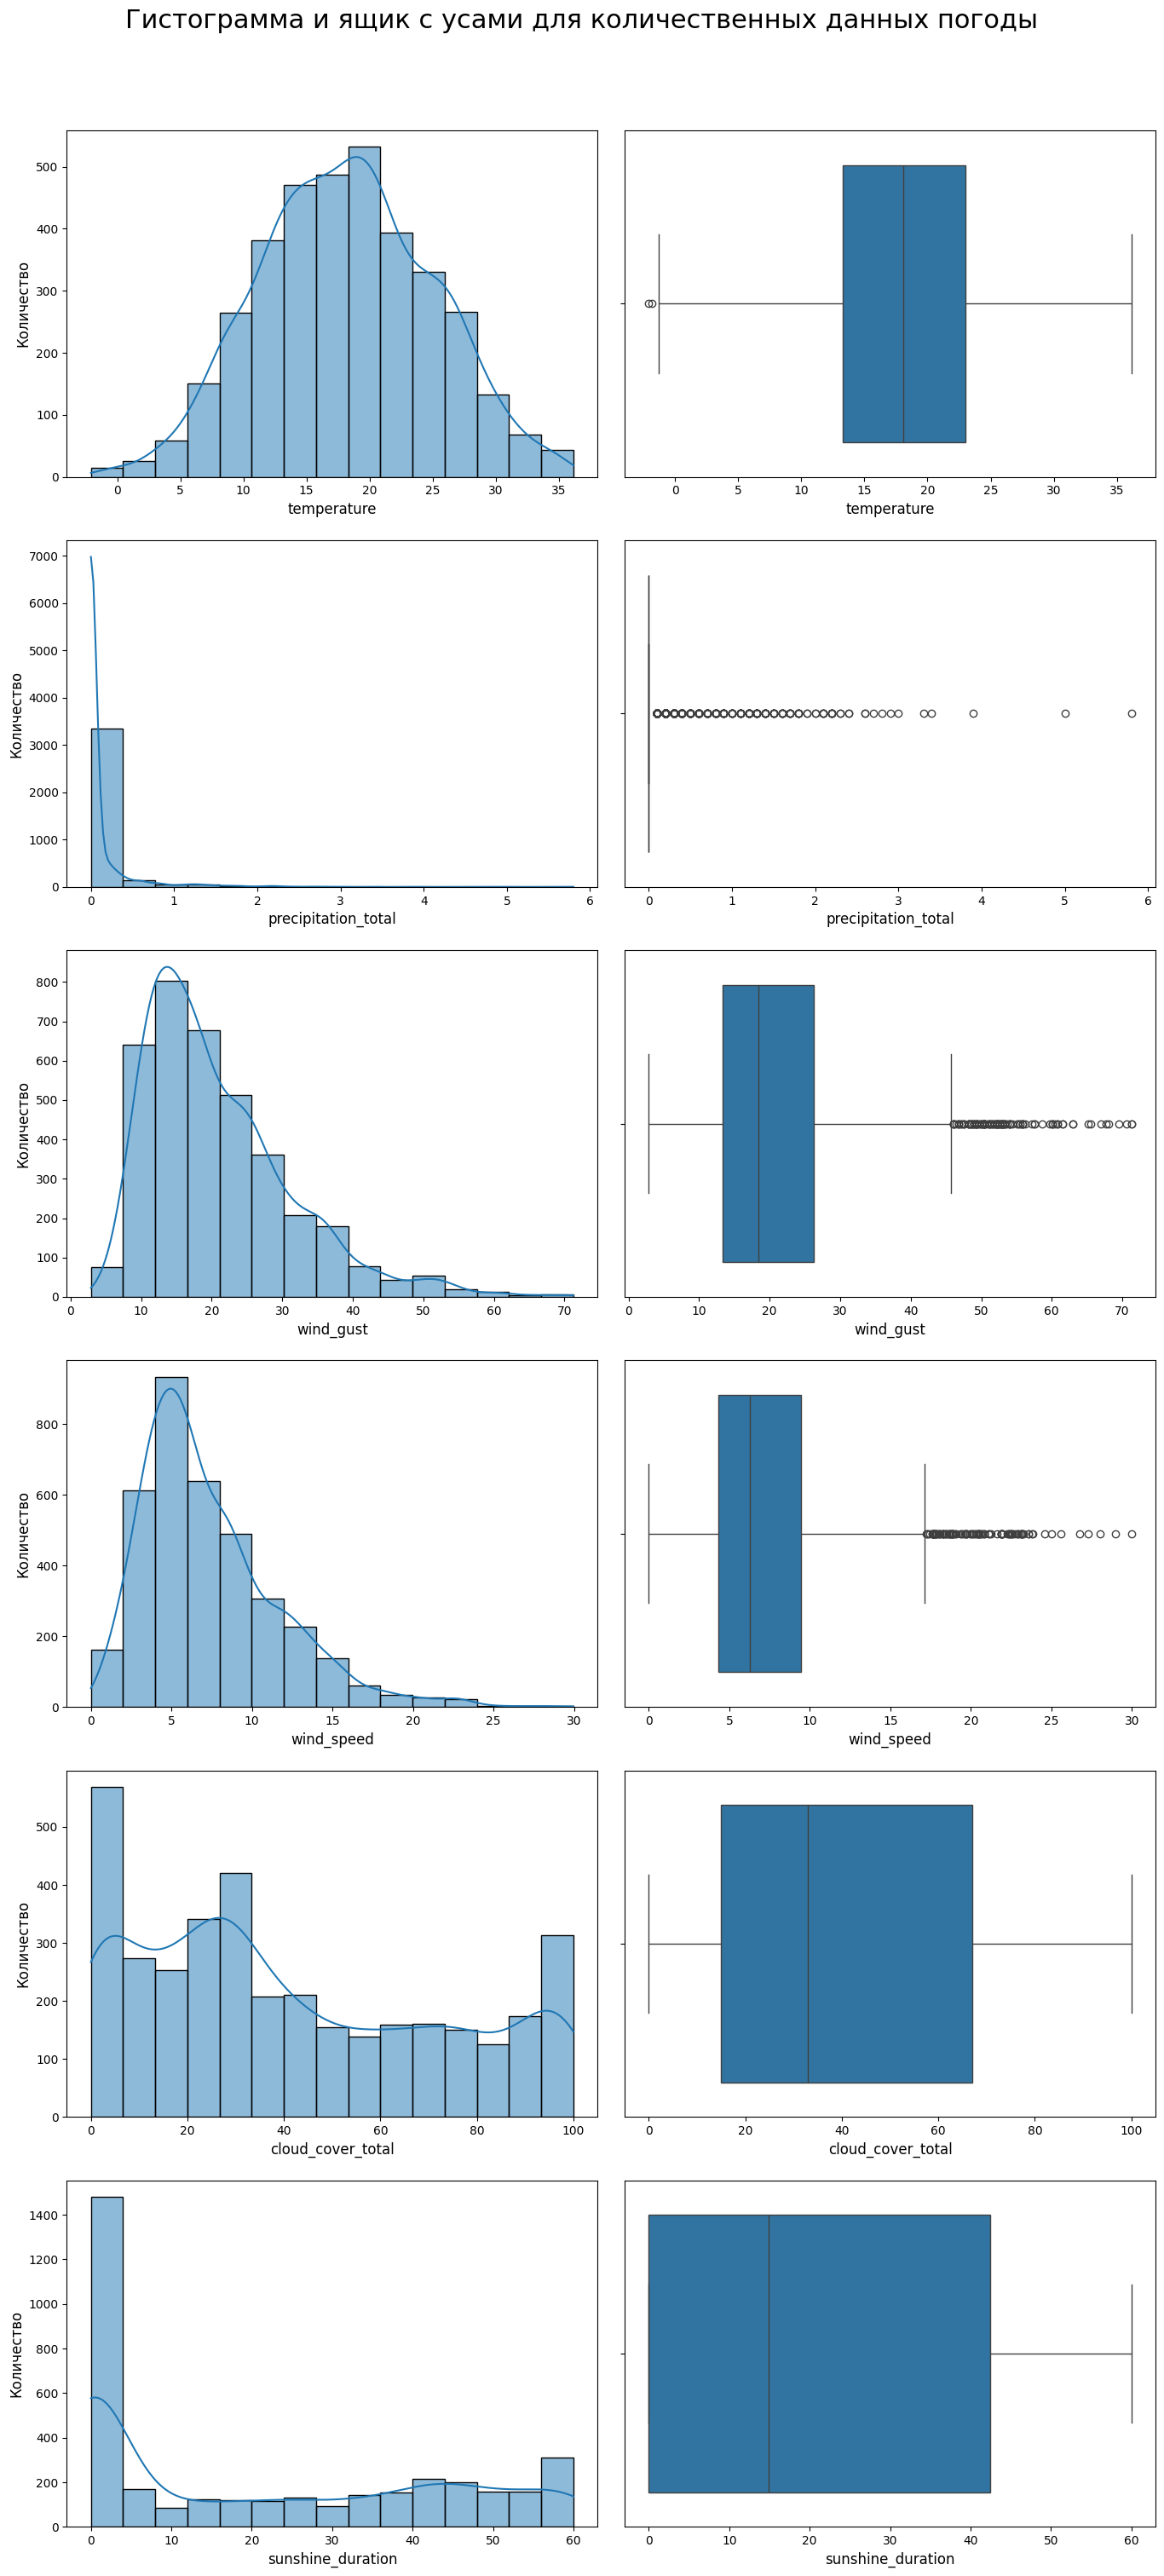

In [451]:
plot_hist(df_weather, integer_data(df_weather), "погоды")

### Исправление опечаток

In [452]:
for x in ["start_location", "end_location"]:
    df_rides = streets_format(df_rides, x)

for x in ["start_district", "end_district"]:
    df_rides = rayons_format(df_rides, x)

### Назначение типов данных

In [453]:
df_rides["promo"] = df_rides["promo"].astype(bool)
df_rides["start_date"] = pd.to_datetime(df_rides["start_date"])
df_rides["end_date"] = pd.to_datetime(df_rides["end_date"])
df_weather["datetime"] = pd.to_datetime(df_weather["datetime"])

## Работа с пропусками и выбросами в датасете поездок

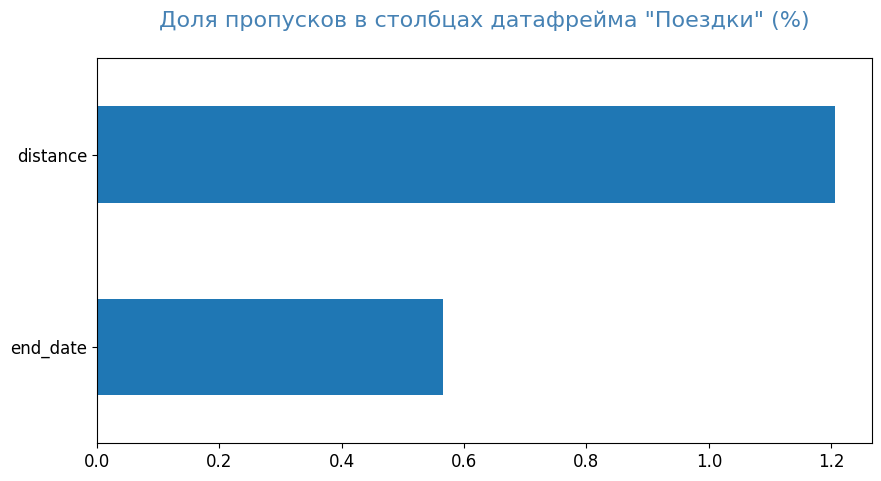

In [454]:
pass_value_barh(df_rides, "Поездки")

In [455]:
df_rides["duration"] = (df_rides["end_date"] - df_rides["start_date"]).apply(
    lambda x: x.total_seconds() / 60
)
df_rides.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667


<Axes: ylabel='distance'>

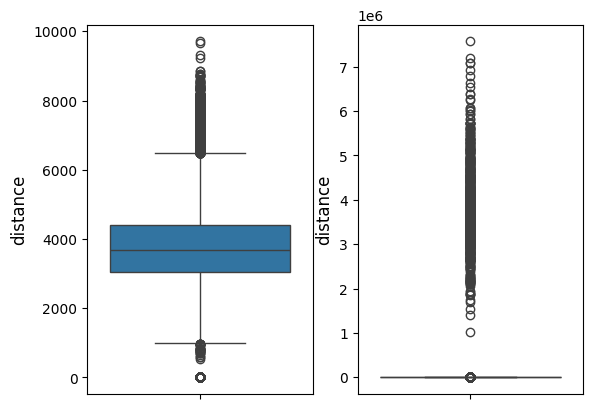

In [456]:
plt.subplot(1, 2, 1)
sns.boxplot(df_rides[df_rides["distance"] < 1000000]["distance"])
plt.subplot(1, 2, 2)
sns.boxplot(df_rides["distance"])

In [457]:
print(df_rides[df_rides["distance"] > 1000000]["distance"].shape[0], df_rides.shape[0])

622 102255


Выбросы по параметру distance начинаются с 1E6, остальные значения напоминают реальные (поездки на самокате в среднем около 4км, >=100км на самокате не проехать), выбросы по параметру distance можно заменить на среднее по группам

<Axes: ylabel='duration'>

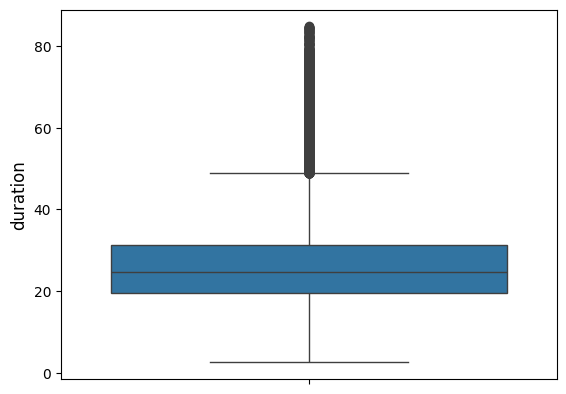

In [458]:
sns.boxplot(df_rides["duration"])

пропуски есть только в 2 базовых столбцах - дистанция и время окончания

выбросы есть только в столбце distance, в этих столбцах можно просто заменить на среднее по группе (место и район старта и место и район финиша)

C:\Users\Pavel\AppData\Local\Temp\ipykernel_29452\248200.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[(x > 1000000) | (x < 10)] = None


<Axes: ylabel='distance'>

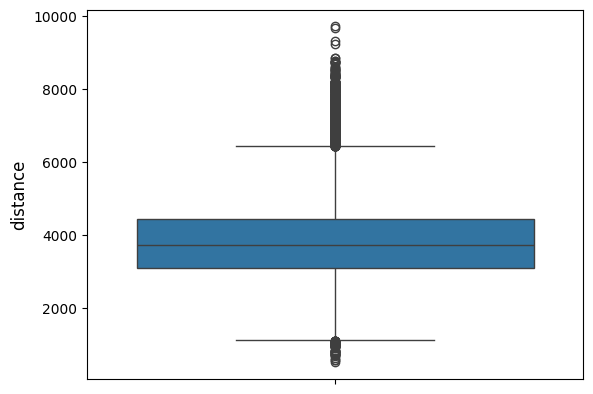

In [459]:
df_rides["distance"] = df_rides["distance"].transform(ejection)
sns.boxplot(df_rides["distance"])

In [460]:
df_rides["avg_speed"] = df_rides["distance"] / df_rides["duration"]
df_rides.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435


In [461]:
df_rides = df_rides.drop_duplicates(subset=["id"])

In [462]:
df_rides["avg_speed"] = df_rides.groupby(
    ["start_location", "start_district", "end_location", "end_district"]
)["avg_speed"].transform(
    lambda x: x.fillna(df_rides["avg_speed"].mean() if x.count() == 0 else x.mean())
)

df_rides.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435


In [463]:
df_rides["distance"] = df_rides["distance"].fillna(
    df_rides["duration"] * df_rides["avg_speed"]
)
df_rides.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435


In [464]:
df_rides[df_rides["distance"].isna() & df_rides["duration"].isna()].shape[0]

18

In [465]:
df_rides[df_rides["distance"].isna()]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
495,100807,2023-04-22 17:58:05,NaT,ломоносова,октябрьский,цветочная,северо-западный,NaN,False,NaN,161.769014
2546,102752,2023-04-24 19:41:16,NaT,октябрьская,заречный,комарова,ленинский,NaN,False,NaN,147.591056
2806,103006,2023-04-25 08:47:46,NaT,восточная,октябрьский,строительная,северо-западный,NaN,False,NaN,142.927047
10158,110004,2023-05-03 18:18:24,NaT,комсомольская,заречный,заводская,северо-западный,NaN,False,NaN,158.311131
15582,115182,2023-05-09 13:11:54,NaT,гоголя,центральный,дорожная,юго-восточный,NaN,False,NaN,148.929230
16517,116078,2023-05-10 18:54:16,NaT,мичурина,ленинский,восточная,октябрьский,NaN,False,NaN,154.040510
21876,121178,2023-05-16 18:30:32,NaT,майская,октябрьский,гагарина,центральный,NaN,False,NaN,145.933047
27939,126949,2023-05-23 06:44:52,NaT,крупской,центральный,буденного,октябрьский,NaN,False,NaN,175.021465
46102,144250,2023-06-09 21:59:33,NaT,энтузиастов,центральный,спортивная,октябрьский,NaN,False,NaN,157.147814
46473,144602,2023-06-10 11:46:28,NaT,спортивная,октябрьский,труда,центральный,NaN,False,NaN,156.840155


Существует 18 записей, где пропущена и дистанция и end_date, можно убрать их как статистический выброс, так как записи ничего не объединяет

In [466]:
df_rides = df_rides.dropna(subset=["distance"])

In [467]:
df_rides["duration"] = df_rides["duration"].fillna(
    df_rides["distance"] / df_rides["avg_speed"]
)
df_rides["end_date"] = df_rides.apply(
    lambda row: (
        row["start_date"] + dt.timedelta(seconds=int(row["duration"] * 60))
        if pd.isna(row["end_date"])
        else row["end_date"]
    ),
    axis=1,
)
df_rides.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435


## Аналитический и графический анализ

### Просмотр финальных датасетов

#### Датасет поездок

In [468]:
df_rides.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435


In [469]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97354 entries, 0 to 102254
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              97354 non-null  int64         
 1   start_date      97354 non-null  datetime64[ns]
 2   end_date        97354 non-null  datetime64[ns]
 3   start_location  97354 non-null  object        
 4   start_district  97354 non-null  object        
 5   end_location    97354 non-null  object        
 6   end_district    97354 non-null  object        
 7   distance        97354 non-null  float64       
 8   promo           97354 non-null  bool          
 9   duration        97354 non-null  float64       
 10  avg_speed       97354 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 8.3+ MB


Размер датасета, а значит и количество поездок

In [470]:
df_rides.shape

(97354, 11)

Пропусков нет


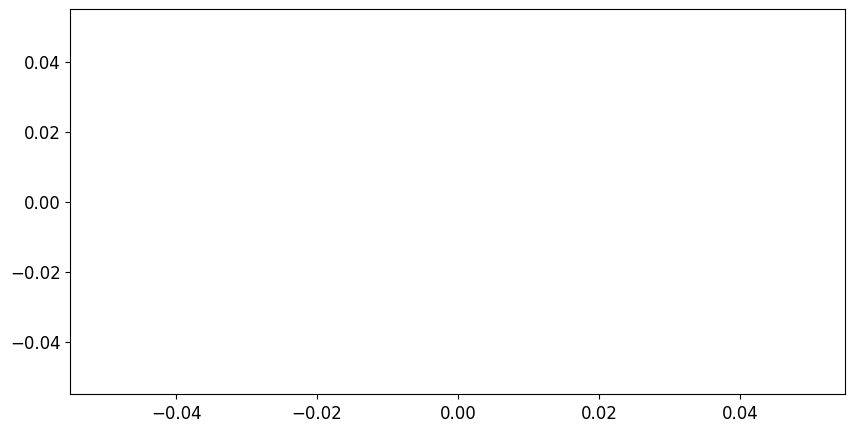

In [471]:
pass_value_barh(df_rides, "Поездки")

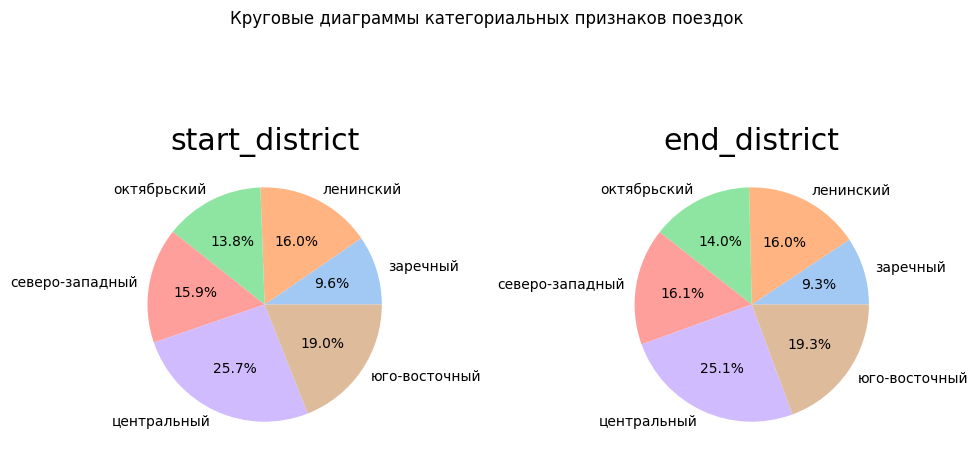

In [472]:
cat_graph(df_rides, ["start_district", "end_district"], "поездок")

#### Датасет погоды

In [473]:
df_weather.head(5)

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,2023-04-01 00:00:00,8.740245,0.1,48.60,21.638964,90.0,0.0
1,2023-04-01 01:00:00,9.040245,0.2,55.44,22.493519,74.0,0.0
2,2023-04-01 02:00:00,8.880245,0.3,55.80,22.264770,72.0,0.0
3,2023-04-01 03:00:00,8.690246,0.3,55.44,21.945240,77.0,0.0
4,2023-04-01 04:00:00,8.630245,0.3,48.96,22.424270,78.0,0.0


In [474]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             3672 non-null   datetime64[ns]
 1   temperature          3617 non-null   float64       
 2   precipitation_total  3642 non-null   float64       
 3   wind_gust            3672 non-null   float64       
 4   wind_speed           3656 non-null   float64       
 5   cloud_cover_total    3652 non-null   float64       
 6   sunshine_duration    3660 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 200.9 KB


Размер датасета, а значит и количество измерений

In [475]:
df_weather.shape

(3672, 7)

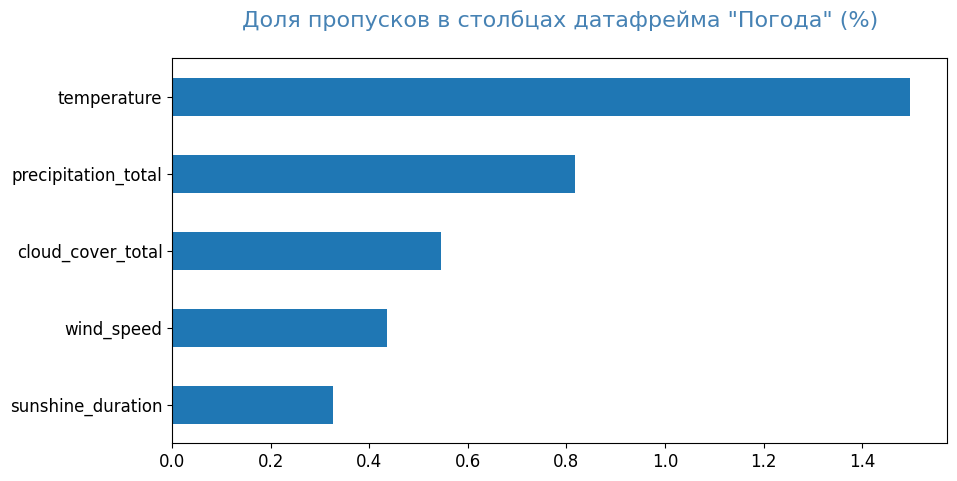

In [476]:
pass_value_barh(df_weather, "Погода")

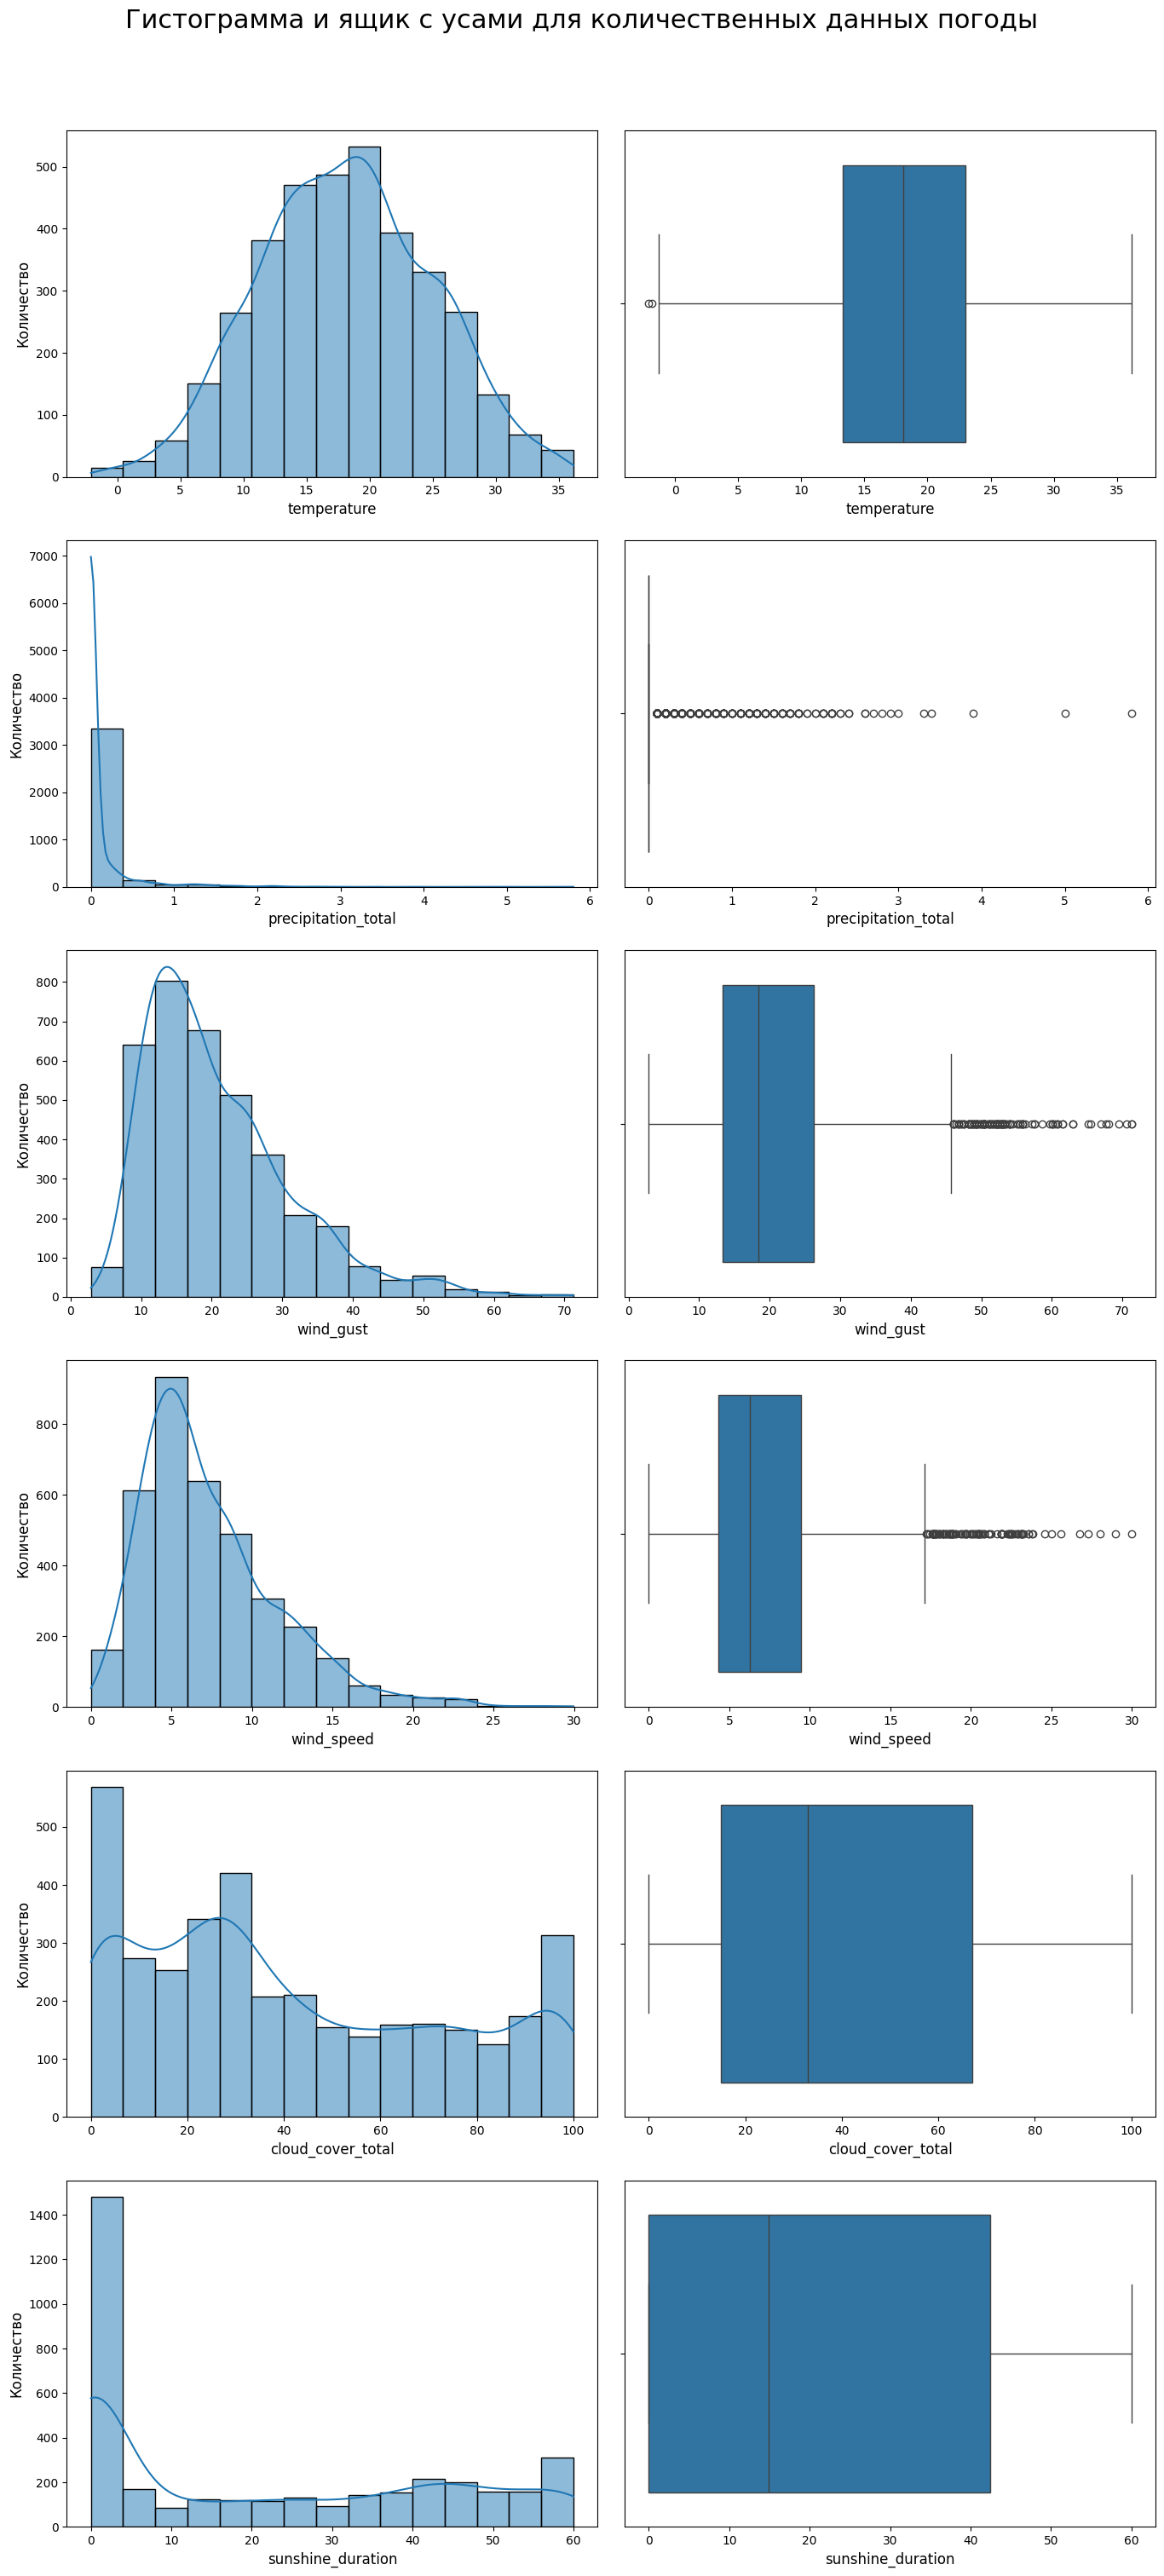

In [477]:
plot_hist(df_weather, integer_data(df_weather), "погоды")